## using pret-raind VGG16
---
we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier.

In [1]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

input_tensor = Input(shape=(512, 512, 3))

vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg16_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [2]:
import pandas as pd
data_df = pd.read_csv('../outputs/target_idx.csv')
data_df.head()

,Image Index,Emphysema
0,00000009_000.png,1
1,00000013_041.png,1
2,00000013_042.png,1
3,00000027_000.png,1
4,00000034_000.png,1


In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255., validation_split=0.1)

img_dir = "../inputs/images/"

train_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="training",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

valid_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="validation",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

Found 1669 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [5]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

In [6]:
for layer in model.layers[:15]:
    layer.trainable = False

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10)

Epoch 1/10
52/52 [==============================] - 3085s 59s/step - loss: 0.7195 - acc: 0.5361 - val_loss: 0.6763 - val_acc: 0.5885
Epoch 2/10
52/52 [==============================] - 3039s 58s/step - loss: 0.6891 - acc: 0.5570 - val_loss: 0.6901 - val_acc: 0.5236
Epoch 3/10
52/52 [==============================] - 3144s 60s/step - loss: 0.6848 - acc: 0.5510 - val_loss: 0.6837 - val_acc: 0.5550
Epoch 4/10
52/52 [==============================] - 3557s 68s/step - loss: 0.6836 - acc: 0.5808 - val_loss: 0.6788 - val_acc: 0.6178
Epoch 5/10
52/52 [==============================] - 2136s 41s/step - loss: 0.6783 - acc: 0.5752 - val_loss: 0.6795 - val_acc: 0.5759
Epoch 6/10
52/52 [==============================] - 2852s 55s/step - loss: 0.6746 - acc: 0.5744 - val_loss: 0.6867 - val_acc: 0.5131
Epoch 7/10
52/52 [==============================] - 3440s 66s/step - loss: 0.6742 - acc: 0.5943 - val_loss: 0.6798 - val_acc: 0.5654
Epoch 8/10
52/52 [==============================] - 3963s 76s/step - 

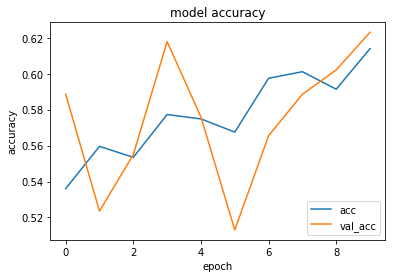

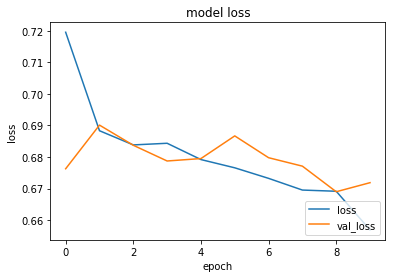

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(history)

In [12]:
import numpy as np
np.savez('../plots/Fine-tuning(VGG16)_train', acc=history.history['acc'], loss=history.history['loss'])
np.savez('../plots/Fine-tuning(VGG16)_valid', acc=history.history['val_acc'], loss=history.history['val_loss'])